In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from scipy.optimize import curve_fit

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
runs=[300,301,302,303,304,305,307]

c_folder="../../data/calibration/"
d_folder="../../data/runData/"

Number of events: 71416


Initial pedestal-based selection performed.
Events left: 71415


Events with multiple hits in first layer removed.
Events left: 42333


Events with hits in the back 5 layers removed.
Events left: 31066




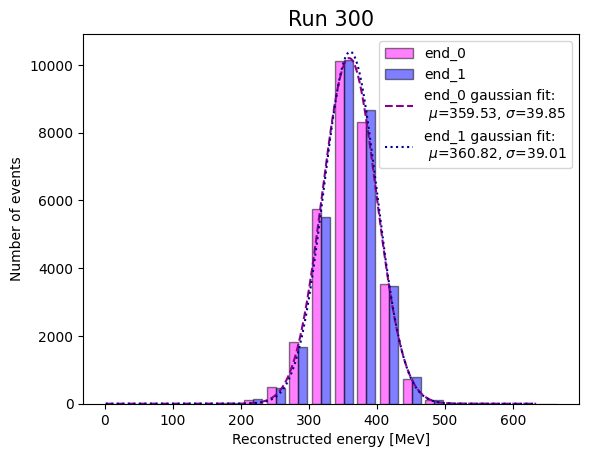

Number of events: 92038


Initial pedestal-based selection performed.
Events left: 91978


Events with multiple hits in first layer removed.
Events left: 63987


Events with hits in the back 5 layers removed.
Events left: 61267




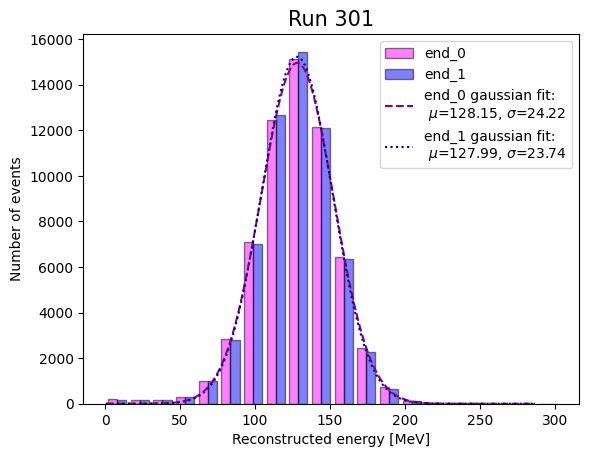

Number of events: 100534


Initial pedestal-based selection performed.
Events left: 99704


Events with multiple hits in first layer removed.
Events left: 75163


Events with hits in the back 5 layers removed.
Events left: 73234




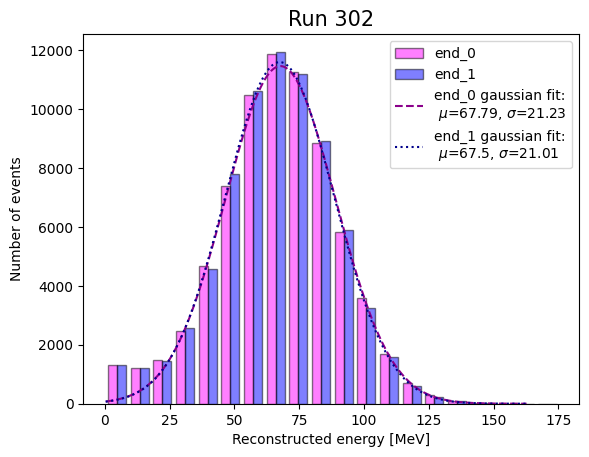

Number of events: 105912


Initial pedestal-based selection performed.
Events left: 104450


Events with multiple hits in first layer removed.
Events left: 80916


Events with hits in the back 5 layers removed.
Events left: 79071




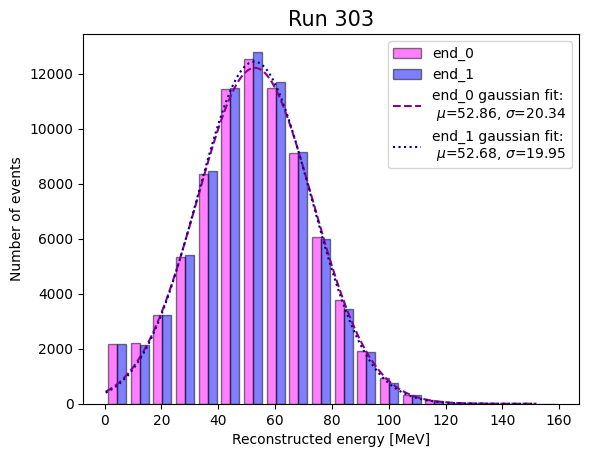

Number of events: 67621


Initial pedestal-based selection performed.
Events left: 66038


Events with multiple hits in first layer removed.
Events left: 53128


Events with hits in the back 5 layers removed.
Events left: 52005




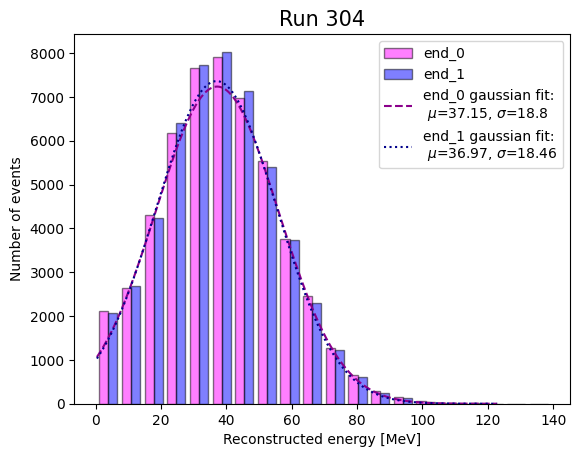

Number of events: 47351


Initial pedestal-based selection performed.
Events left: 46271


Events with multiple hits in first layer removed.
Events left: 37232


Events with hits in the back 5 layers removed.
Events left: 36506




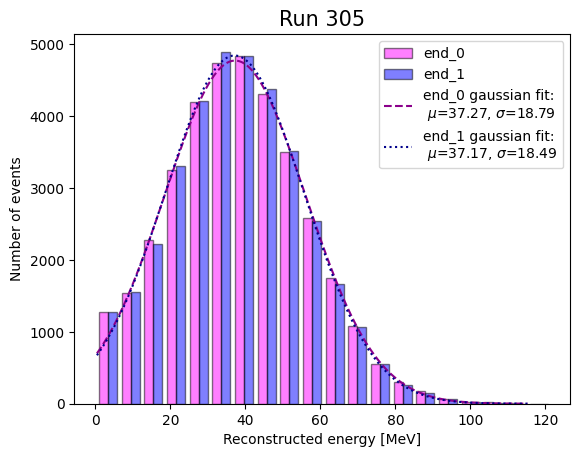

Number of events: 37098


Initial pedestal-based selection performed.
Events left: 36254


Events with multiple hits in first layer removed.
Events left: 29090


Events with hits in the back 5 layers removed.
Events left: 28498




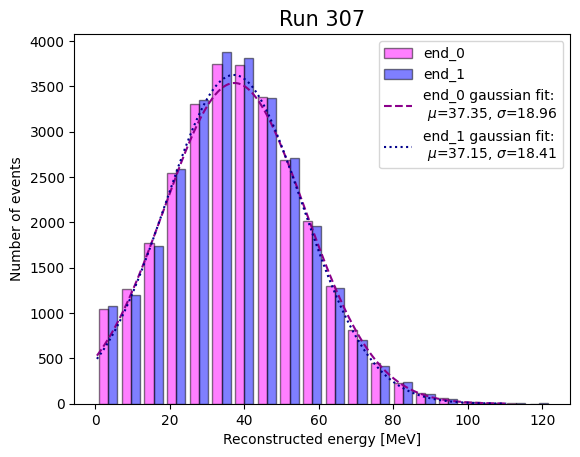

In [4]:
p0_s=[]
p1_s=[]
for r_n in runs:
    # make folder for plots
    Path("../../plots").mkdir(parents=True, exist_ok=True)
    Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
    p_folder="../../plots/run_"+str(r_n)+"/"

    p,m,r=import_data(c_folder,d_folder, r_n, is_it_pulsed=False)
    r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=False)
    r=first_layer_cut(r)
    r=back_layer_cut(r,5)

    p0,p1=make_gaussian_fit_plot(r,m,r_n,p_folder, save_plot=True)

    p0_s.append(p0[:-1])
    p1_s.append(p1[:-1])

In [32]:
def make_result_df(p0_s, p1_s, run_numbers, calibration_folder, exclude_high_energy=False):
    run_info=pd.read_csv(calibration_folder+"/runs.csv", index_col="run_number").drop("Unnamed: 0", axis=1)

    params=pd.DataFrame(np.append(np.array(p0_s),np.array(p1_s), axis=1), columns=["mu_end0", "sigma_end0", "mu_end1", "sigma_end1"])
    params["run_number"]=np.array(run_numbers)
    params.set_index(["run_number"], inplace=True)
    
    result_df=params.join(run_info, how='inner')
    result_df["mu_end0"]/=1000
    result_df["mu_end1"]/=1000
    result_df["sigma_end0"]/=1000
    result_df["sigma_end1"]/=1000
    if ecxlude_high_energy==True:
        low_result_df=results[results["beam_energy"]<=2]
        return result_df, low_result_df
    else:
        return result_df

In [30]:
def linear_fit(result_df, exclude_high_energy=False, low_result_df=None):
    param, pcov = curve_fit(linear, result_df["beam_energy"], result_df["mu_end0"])
    perr=np.sqrt(np.diag(pcov))

    if exclude_high_energy==True:
        param_low, pcov_low = curve_fit(linear, low_result_df["beam_energy"], low_result_df["mu_end0"])
        perr_low=np.sqrt(np.diag(pcov_low))
        return param,perr, param_low, perr_low
    else:
        return param, perr

In [31]:
def linear_plot(result_df,end, param, perr, exclude_high_energy=False, low_result_df=None, param_low=None, perr_low=None, save_plot=False):
    sample=np.linspace(0.1, 5, 1000)
    mu="mu_end"+str(int(end))
    sigma="sigma_end"+str(int(end))
    plt.errorbar(result_df["beam_energy"], result_df[mu], result_df[sigma],
             linestyle='', marker='o', color="magenta", label="end_"+str(end), capsize=5)
    plt.plot(sample, linear(sample, *param), color="gray",linestyle="--",
         label=r"linear fit ""\n"" a="+str(round(param[0],3))+"$\pm$"+str(round(perr[0],4))+
         ",  b="+str(round(param[1],3))+"$\pm$"+str(round(perr[1],4)))
    if exclude_high_energy==True:
        plt.plot(sample, linear(sample, *param_low), color="black",
                 label=r"linear fit w/o 4 GeV ""\n"" a="+str(round(param_low[0],3))+"$\pm$"+str(round(perr_low[0],4))+
                 ",  b="+str(round(param_low[1],4))+"$\pm$"+str(round(perr_low[1],4)))
    plt.xlabel("Beam energy [GeV]")
    plt.ylabel("Mean reconstructed energy [GeV]")
    plt.legend()
    if save_plot==True:
        plt.savefig("../../plots/hcal_linearity_electron.png", bbox_inches='tight')
    plt.show()
    return

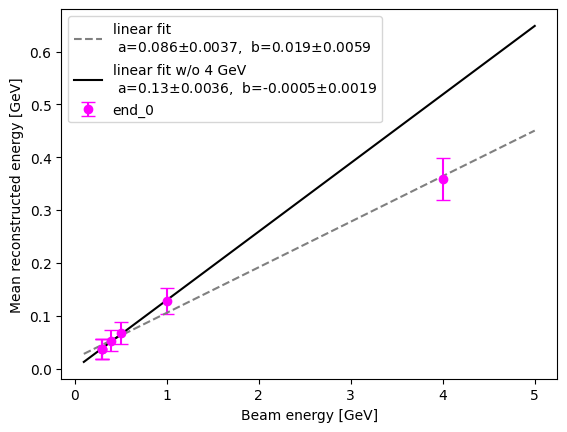

In [7]:
sample=np.linspace(0.1, 5, 1000)
plt.errorbar(results["beam_energy"], results["mu_end0"], results["sigma_end0"],
             linestyle='', marker='o', color="magenta", label="end_0",capsize=5)
plt.plot(sample, linear(sample, *param), color="gray",linestyle="--",
         label=r"linear fit ""\n"" a="+str(round(param[0],3))+"$\pm$"+str(round(perr[0],4))+
         ",  b="+str(round(param[1],3))+"$\pm$"+str(round(perr[1],4)))

plt.plot(sample, linear(sample, *param_low), color="black",
         label=r"linear fit w/o 4 GeV ""\n"" a="+str(round(param_low[0],3))+"$\pm$"+str(round(perr_low[0],4))+
         ",  b="+str(round(param_low[1],4))+"$\pm$"+str(round(perr_low[1],4)))

plt.xlabel("Beam energy [GeV]")
plt.ylabel("Mean reconstructed energy [GeV]")
plt.legend()
plt.show()

In [12]:
truth=results["sigma_end0"]/results["mu_end0"]
truth_low=exclude_high_energy["sigma_end0"]/exclude_high_energy["mu_end0"]

param, perr=curve_fit(hyperbolic, results["beam_energy"], truth)
param_low, perr_low=curve_fit(hyperbolic, exclude_high_energy["beam_energy"], truth_low)

perr=np.sqrt(np.diag(pcov))
perr_low=np.sqrt(np.diag(pcov_low))

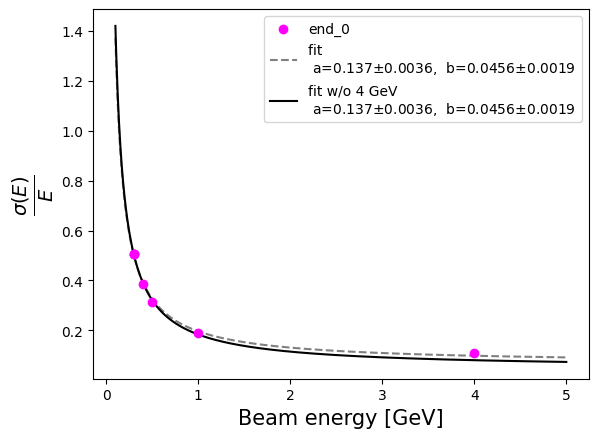

In [20]:
plt.scatter(results["beam_energy"], results["sigma_end0"]/results["mu_end0"], color="magenta",zorder=4, label="end_0")

plt.plot(sample, hyperbolic(sample, *param), linestyle="--", color="gray",zorder=2,
         label=r"fit ""\n"" a="+str(round(param_low[0],3))+"$\pm$"+str(round(perr_low[0],4))+
         ",  b="+str(round(param_low[1],4))+"$\pm$"+str(round(perr_low[1],4)))

plt.plot(sample, hyperbolic(sample, *param_low), linestyle="-", color="black",zorder=3,
         label=r"fit w/o 4 GeV ""\n"" a="+str(round(param_low[0],3))+"$\pm$"+str(round(perr_low[0],4))+
         ",  b="+str(round(param_low[1],4))+"$\pm$"+str(round(perr_low[1],4)))
plt.xlabel("Beam energy [GeV]", fontsize=15)
plt.ylabel(r"$\frac{\sigma (E)}{E}$", fontsize=20)
plt.legend()
plt.show()

Number of events: 47351


Initial pedestal-based selection performed.
Events left: 46271


Events with multiple hits in first layer removed.
Events left: 37232


Events with hits in the back 5 layers removed.
Events left: 36506




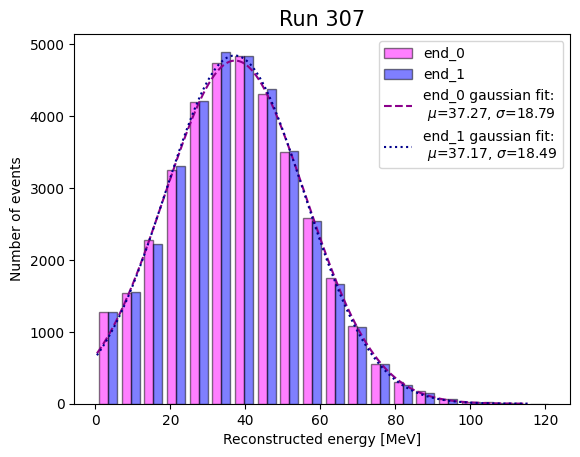

CPU times: user 9.32 s, sys: 1.93 s, total: 11.3 s
Wall time: 11.3 s


In [4]:
%%time
r_n=307

Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/run_"+str(r_n)).mkdir(parents=True, exist_ok=True)
p_folder="../../plots/run_"+str(r_n)+"/"

p,m,r=import_data(c_folder,d_folder, 305, is_it_pulsed=False)
r=select_bars_with_data(r,p, subtract_pedestal=True, is_it_pulsed=False)
r=first_layer_cut(r)
r=back_layer_cut(r,5)
p0,p1=make_gaussian_fit_plot(r,m,r_n,p_folder, save_plot=False)